In [1]:
import numpy as np #Numerical Analysis
import pandas as pd #ETL
import matplotlib.pyplot as plt #Data Visualization
import seaborn as sns #Data Visualization
import warnings #Supressing Unnecessary Warnings

In [2]:
import os

In [3]:
os.getcwd()

'C:\\Users\\athar\\OneDrive\\Desktop\\Rutgers\\Statistical Modeling\\Final Project - Stat Modeling'

In [4]:
#Options and Settings
warnings.simplefilter('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
colors = sns.color_palette("Set3", 10)

In [5]:
#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler,MinMaxScaler,QuantileTransformer

In [6]:
price_data = pd.read_csv('archive/price_data.csv')
client_data = pd.read_csv('archive/client_data.csv')

User Defined Functions

In [7]:
# Function to label partitions of pie chart
def annotation_labeling(lbl, vals):
    absolute = int(np.round(lbl/100.*np.sum(vals)))
    return "{:.1f}%\n({:d})".format(lbl, absolute)

In [8]:
# To find the upper bound and lower bound of the distribution using inter-quantile range
def iqr_range(arr):
    q1 = np.quantile(arr,0.25)
    q3 = np.quantile(arr,0.75)
    iqr = q3-q1
    return q1-(iqr*1.5),q3+(iqr*1.5)

In [9]:
def outlier_removal(df,column,drop_percentage=0.05):
    
    actual_rows = df.shape[0]
    lower_bound,upper_bound = iqr_range(df[column].values)
    outliers = df[ (df[column]<lower_bound) | (df[column]>upper_bound) ]
    print('Total No of rows in actual dataframe : ',actual_rows,'\nTotal No of rows in outliers : ',outliers.shape[0])
    if outliers.shape[0] <= round(actual_rows*drop_percentage):
        df.drop(outliers.index,inplace=True)
    
    return df

<H2>Exploring Price Data</h2>

In [10]:
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [11]:
#Changing datatype : price date => object -> datetime64
price_data = price_data.astype({'price_date' : 'datetime64'})

In [12]:
print('No of unique clients : ',price_data.id.nunique())
#basic Stats
price_data.describe()

No of unique clients :  16096


,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
std,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


<H3>Merging Client Dataset and Price Dataset</H3>

In [13]:
client_churn_info = client_data[['id','churn']]
price_df = client_churn_info.merge(price_data,on='id')

In [14]:
#Merged Dataset
price_df.head()

,id,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
1,24011ae4ebbe3035111d65fa7c15bc57,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
2,24011ae4ebbe3035111d65fa7c15bc57,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
3,24011ae4ebbe3035111d65fa7c15bc57,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
4,24011ae4ebbe3035111d65fa7c15bc57,1,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383


Univariant Analysis
Plotting histogram to see the distribution of the data.

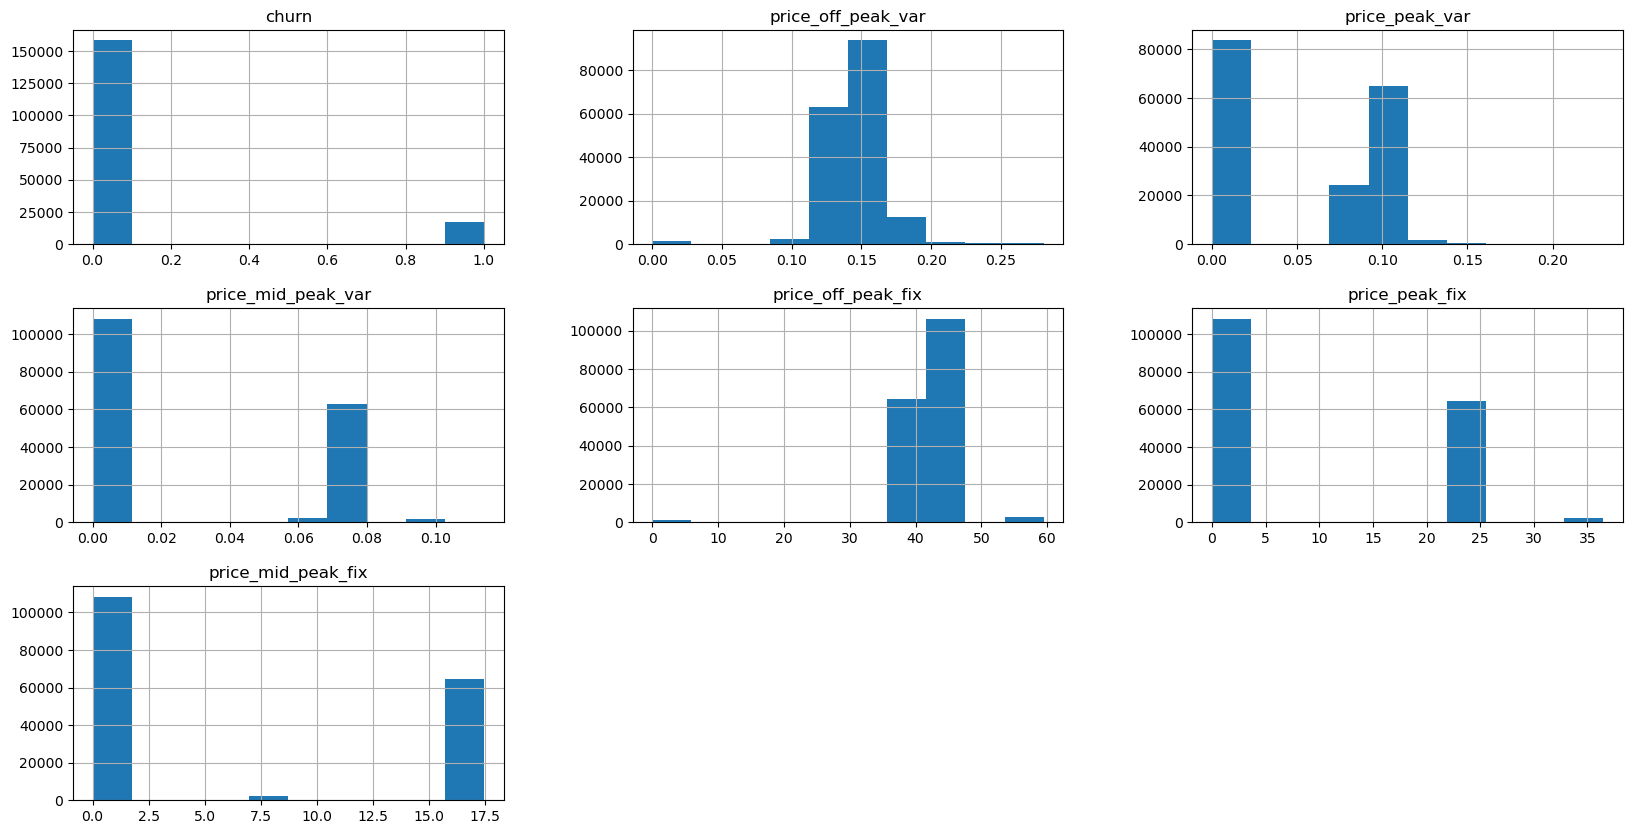

In [15]:
price_df.groupby(['id','price_date']).mean().hist(figsize=(20,10))
plt.show()

The HistPlot shows that the data is skewed and show be treated before model creation.

<h3>Plotting Energy and Power Prices</h3>

In [16]:
#Spliting the dataset into chrun and non-churn price by price date
churn_grp_price = price_df[price_df['churn']==1].groupby(['price_date']).mean()
non_churn_grp_price = price_df[price_df['churn']==0].groupby('price_date').mean()

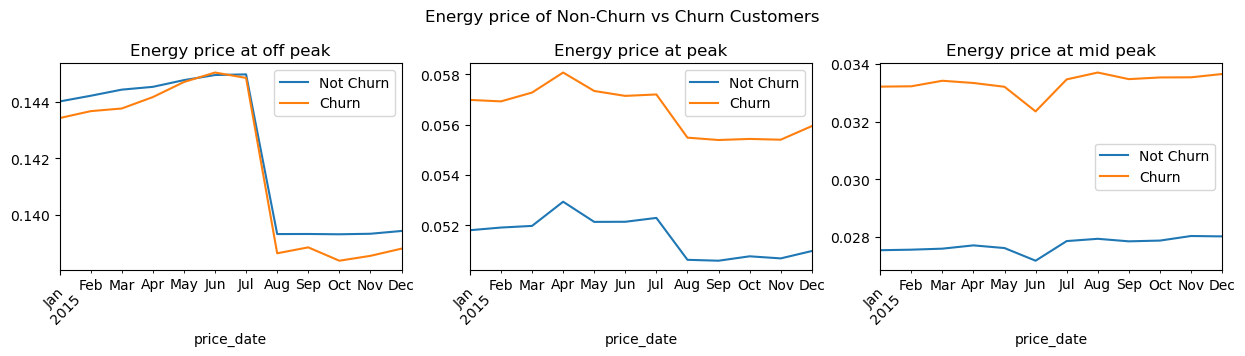

In [17]:
#Plotting average price of energy by month 
plt.figure(figsize=(15,3))
plt.xticks(rotation=45)
plt.subplot(131)
non_churn_grp_price.price_off_peak_var.plot()
churn_grp_price.price_off_peak_var.plot()
plt.xticks(rotation=45)
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at off peak')
plt.subplot(132)
non_churn_grp_price.price_peak_var.plot()
churn_grp_price.price_peak_var.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at peak')
plt.xticks(rotation=45)
plt.subplot(133)
non_churn_grp_price.price_mid_peak_var.plot()
churn_grp_price.price_mid_peak_var.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at mid peak')
plt.xticks(rotation=45)
plt.suptitle('Energy price of Non-Churn vs Churn Customers')
plt.subplots_adjust(top=0.8)
plt.show()

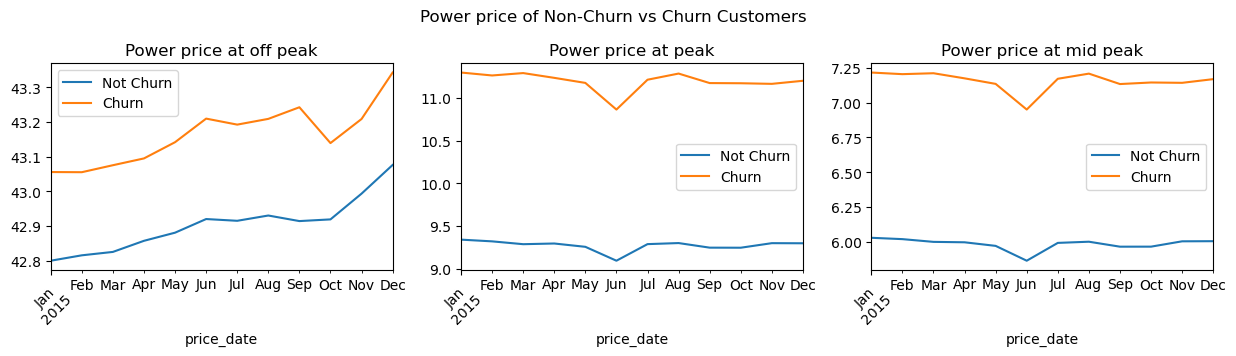

In [18]:
#Plotting average price of power by month
plt.figure(figsize=(15,3))
plt.xticks(rotation=45)
plt.subplot(131)
non_churn_grp_price.price_off_peak_fix.plot()
churn_grp_price.price_off_peak_fix.plot()
plt.xticks(rotation=45)
plt.legend(['Not Churn','Churn'])
plt.title('Power price at off peak')
plt.subplot(132)
non_churn_grp_price.price_peak_fix.plot()
churn_grp_price.price_peak_fix.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Power price at peak')
plt.xticks(rotation=45)
plt.subplot(133)
non_churn_grp_price.price_mid_peak_fix.plot()
churn_grp_price.price_mid_peak_fix.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Power price at mid peak')
plt.xticks(rotation=45)
plt.suptitle('Power price of Non-Churn vs Churn Customers')
plt.subplots_adjust(top=0.8)
plt.show()


There is some variation of price between churn and un-churn clients. Churned clients have slightly low off-peak energy prices and high off-peak prices. But we can't confidently say this is the factor for churn. We need to analyze the data further to arrive at a concrete conclusion.

<H3>Correlational Heatmap</H3>
Before merging the dataset with the client dataset, we should conduct a correlation analysis to identify the features replicating the same information.

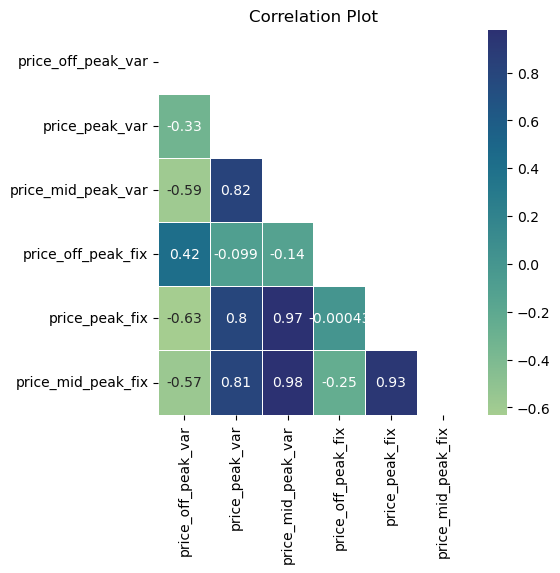

In [19]:
plt.figure(figsize=(5,5))
pd_corr = price_data.corr()
mask = np.triu(np.ones_like(pd_corr))
sns.heatmap(pd_corr,annot=True,cmap="crest",linewidth=.5,mask=mask)
plt.title('Correlation Plot')
plt.show()

In [20]:
price_data.drop(['price_peak_var','price_peak_fix','price_mid_peak_var'],axis=1,inplace=True)

High co-relation coefficient values between two features denote the high dependency between them. It shows that the two features convey the same information. So one of the features can be dropped.

<H3>Feature Engineering</H3>

Since the price information is monthly, we wont be able to merge it directly with the client data. Some feature transformations need to be done to derive the yearly prices. The off-peak and mid-peak of energy follow a linear flow, so we can take the average of the monthly prices. The energy off-peak price was high at the beginning of the year and low at the end of the year. So we take the price difference as a consolidated value.

In [21]:
#Filtering out the January and December energy off peak price
price_off_peak_energy = price_data[['id','price_off_peak_var']]
jan_prices = price_off_peak_energy.groupby('id').price_off_peak_var.first().reset_index().rename(columns={'price_off_peak_var':'price_off_peak_var_jan'})
dec_prices = price_off_peak_energy.groupby('id').last().price_off_peak_var.reset_index().rename(columns={'price_off_peak_var':'price_off_peak_var_dec'})

In [22]:
price_data.drop('price_off_peak_var',axis=1,inplace=True)
#Taking average of Power off-peak and mid-peak
price_data = price_data.groupby('id').mean().reset_index()

In [23]:
#Calculating Energy off peak difference
price_data = price_data.merge(jan_prices,on='id').merge(dec_prices,on='id')
price_data['energy_off_peak_variation'] = price_data.price_off_peak_var_jan - price_data.price_off_peak_var_dec
price_data.drop(['price_off_peak_var_jan','price_off_peak_var_dec'],axis=1,inplace=True)

In [24]:
#Final price dataset
price_data.head()

,id,price_off_peak_fix,price_mid_peak_fix,energy_off_peak_variation
0,0002203ffbb812588b632b9e628cc38d,40.701732,16.280694,0.006192
1,0004351ebdd665e6ee664792efc4fd13,44.385450,0.000000,0.004104
2,0010bcc39e42b3c2131ed2ce55246e3c,45.319710,0.000000,-0.050443
3,0010ee3855fdea87602a5b7aba8e42de,40.647427,16.258971,0.010018
4,00114d74e963e47177db89bc70108537,44.266930,0.000000,0.003994


<H3>Exploring Client Data</H3>

In [25]:
#Inspecting Client Data
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


The activity_new (category of the company's activity) data is not provided.

In [26]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [27]:
#Changing datatype
client_data = client_data.astype({
    'date_activ' : 'datetime64',
    'date_end' : 'datetime64',
    'date_modif_prod' : 'datetime64',
    'date_renewal' : 'datetime64',
})

<h3>Data Cleaning and Feature Engineering</h3>

In [28]:
#Changing hashed values to meaningful labels for easy understanding.
print('Unique Sales Channels : \n',client_data.channel_sales.unique())
print('\nUnique Origin Campaign : \n',client_data.origin_up.unique())

Unique Sales Channels : 
 ['foosdfpfkusacimwkcsosbicdxkicaua' 'MISSING'
 'lmkebamcaaclubfxadlmueccxoimlema' 'usilxuppasemubllopkaafesmlibmsdf'
 'ewpakwlliwisiwduibdlfmalxowmwpci' 'epumfxlbckeskwekxbiuasklxalciiuu'
 'sddiedcslfslkckwlfkdpoeeailfpeds' 'fixdbufsefwooaasfcxdxadsiekoceaa']

Unique Origin Campaign : 
 ['lxidpiddsbxsbosboudacockeimpuepw' 'kamkkxfxxuwbdslkwifmmcsiusiuosws'
 'ldkssxwpmemidmecebumciepifcamkci' 'MISSING'
 'usapbepcfoloekilkwsdiboslwaxobdp' 'ewxeelcelemmiwuafmddpobolfuxioce']


In [29]:
channel_mask = {
    'MISSING':'missing_data',
    'foosdfpfkusacimwkcsosbicdxkicaua':'channel_1',
    'lmkebamcaaclubfxadlmueccxoimlema':'channel_2',
    'usilxuppasemubllopkaafesmlibmsdf':'channel_3',
    'ewpakwlliwisiwduibdlfmalxowmwpci':'channel_4',
    'epumfxlbckeskwekxbiuasklxalciiuu':'channel_5',
    'sddiedcslfslkckwlfkdpoeeailfpeds':'channel_6',
    'fixdbufsefwooaasfcxdxadsiekoceaa':'channel_7',
}
origin_mask = {
    'lxidpiddsbxsbosboudacockeimpuepw' : 'origin_1',
    'kamkkxfxxuwbdslkwifmmcsiusiuosws' : 'origin_2',
    'ldkssxwpmemidmecebumciepifcamkci' : 'origin_3',
    'usapbepcfoloekilkwsdiboslwaxobdp' : 'origin_4',
    'ewxeelcelemmiwuafmddpobolfuxioce' : 'origin_5',
    'MISSING' : 'origin_missing'
}
client_data.replace({
    'has_gas' : {
        't':1,'f':0
    },
    'channel_sales':channel_mask,
    'origin_up':origin_mask,
},inplace=True)
#Labeled Data
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,channel_1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,3,origin_1,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,missing_data,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,6,origin_2,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,channel_1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,6,origin_2,13.856,0
3,bba03439a292a1e166f80264c16191cb,channel_2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,6,origin_2,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,missing_data,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,6,origin_2,19.800,0


In [30]:
#contract_modification_interval : no of years in which the client last modified their contract.
#contract_interval : no of years client travelled with us.
client_data['contract_modification_interval'] = client_data.date_modif_prod.dt.year - client_data.date_activ.dt.year
client_data['contract_interval'] = client_data.date_end.dt.year - client_data.date_activ.dt.year

In [31]:
price_data.head()

,id,price_off_peak_fix,price_mid_peak_fix,energy_off_peak_variation
0,0002203ffbb812588b632b9e628cc38d,40.701732,16.280694,0.006192
1,0004351ebdd665e6ee664792efc4fd13,44.385450,0.000000,0.004104
2,0010bcc39e42b3c2131ed2ce55246e3c,45.319710,0.000000,-0.050443
3,0010ee3855fdea87602a5b7aba8e42de,40.647427,16.258971,0.010018
4,00114d74e963e47177db89bc70108537,44.266930,0.000000,0.003994


<h3>Merging Client and Price Data</h3>

In [32]:
df = client_data.merge(price_data,on='id')
print('Total No of Clients in Price Dataset : ',price_data.id.nunique(),'\nTotal No of Clients in Client Dataset : ',client_data.id.nunique(),'\nTotal No of Clients after merging : ',df.id.nunique())

Total No of Clients in Price Dataset :  16096 
Total No of Clients in Client Dataset :  14606 
Total No of Clients after merging :  14606


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14606 entries, 0 to 14605
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

Correlation Analysis
We have around 31 features.Some of features are derived quantities, by conducting correlation analysis we can able to reduce the highly correlated features.

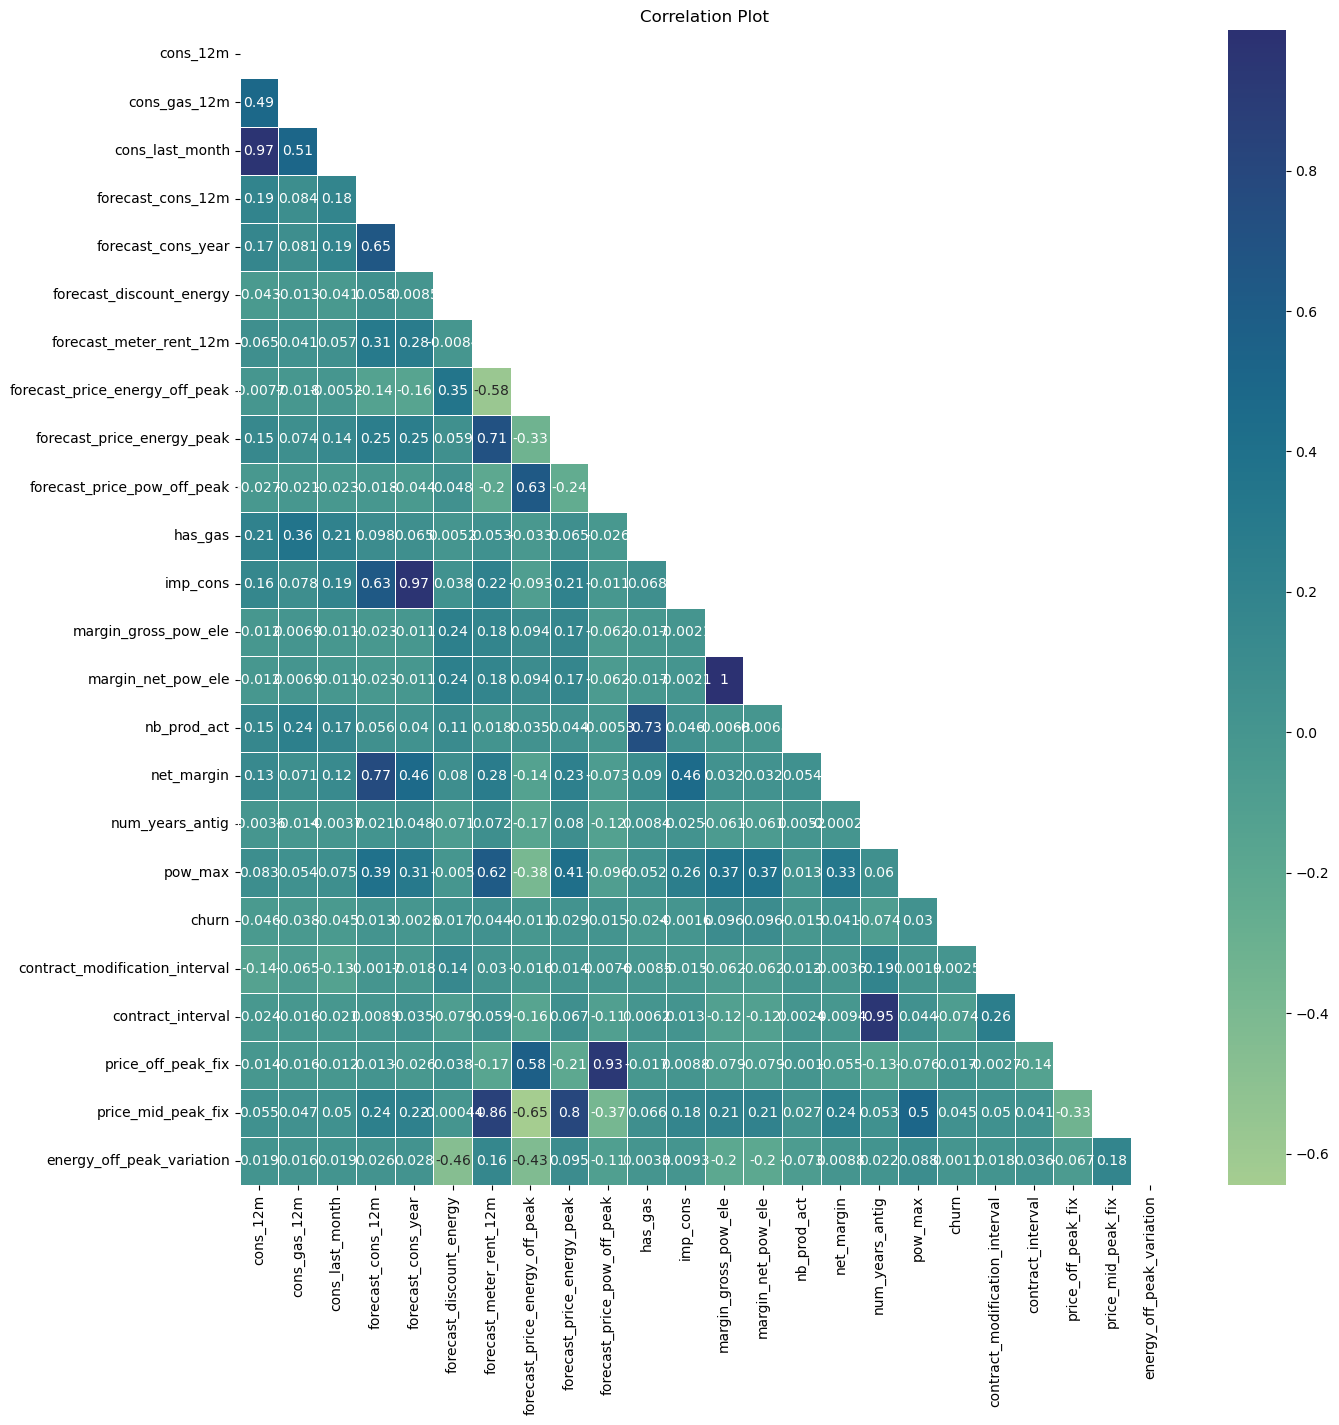

In [34]:
plt.figure(figsize=(15,15))
df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr))
sns.heatmap(df_corr,annot=True,cmap="crest",linewidth=.5,mask=mask)
plt.title('Correlation Plot')
plt.show()

Dropping Highly Correlated and Unwanted Columns

In [35]:
df.drop([
    #Highly correlated columns
    'cons_last_month','forecast_cons_12m', 'forecast_cons_year','forecast_meter_rent_12m',
    'forecast_meter_rent_12m', 'forecast_price_energy_off_peak','forecast_price_energy_peak', 
    'forecast_price_pow_off_peak','margin_gross_pow_ele', 'nb_prod_act',
    'num_years_antig',
    #Unwanted Columns
    'id','date_activ','date_end','date_renewal','date_modif_prod',
],axis=1,inplace=True)

In [36]:
df.head()

,channel_sales,cons_12m,cons_gas_12m,forecast_discount_energy,has_gas,imp_cons,margin_net_pow_ele,net_margin,origin_up,pow_max,churn,contract_modification_interval,contract_interval,price_off_peak_fix,price_mid_peak_fix,energy_off_peak_variation
0,channel_1,0,54946,0.0,1,0.00,25.44,678.99,origin_1,43.648,1,2,3,40.942265,14.901340,-0.020057
1,missing_data,4660,0,0.0,0,0.00,16.38,18.89,origin_2,13.800,0,0,7,44.311375,0.000000,0.003767
2,channel_1,544,0,0.0,0,0.00,28.60,6.60,origin_2,13.856,0,0,6,44.385450,0.000000,0.004670
3,channel_2,1584,0,0.0,0,0.00,30.22,25.46,origin_2,13.200,0,0,6,44.400265,0.000000,0.004547
4,missing_data,4425,0,0.0,0,52.32,44.91,47.98,origin_2,19.800,0,0,6,40.688156,16.275263,0.006192


In [37]:
df.describe()

,cons_12m,cons_gas_12m,forecast_discount_energy,has_gas,imp_cons,margin_net_pow_ele,net_margin,pow_max,churn,contract_modification_interval,contract_interval,price_off_peak_fix,price_mid_peak_fix,energy_off_peak_variation
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,0.966726,0.181501,152.786896,24.562517,189.264522,18.135136,0.097152,1.890251,5.487060,42.928890,6.097680,0.004566
std,5.734653e+05,1.629731e+05,5.108289,0.385446,341.369366,20.230280,311.798130,13.534743,0.296175,2.298371,1.659825,4.550759,7.770748,0.012049
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,3.300000,0.000000,0.000000,2.000000,0.000000,0.000000,-0.168958
25%,5.674750e+03,0.000000e+00,0.000000,0.000000,0.000000,14.280000,50.712500,12.500000,0.000000,0.000000,4.000000,40.688156,0.000000,0.003520
50%,1.411550e+04,0.000000e+00,0.000000,0.000000,37.395000,21.640000,112.530000,13.856000,0.000000,0.000000,5.000000,44.281745,0.000000,0.005344
75%,4.076375e+04,0.000000e+00,0.000000,0.000000,193.980000,29.880000,243.097500,19.172500,0.000000,4.000000,6.000000,44.370635,16.248109,0.007829
max,6.207104e+06,4.154590e+06,30.000000,1.000000,15042.790000,374.640000,24570.650000,320.000000,1.000000,12.000000,13.000000,59.286190,16.818917,0.148477


In [38]:
df.drop_duplicates(subset=['cons_12m',
       'imp_cons', 'net_margin',
       'pow_max', 'churn', 'price_off_peak_fix', 'price_mid_peak_fix',
       'energy_off_peak_variation'],ignore_index=True,inplace=True)

In [39]:
df.columns

Index(['channel_sales', 'cons_12m', 'cons_gas_12m', 'forecast_discount_energy',
       'has_gas', 'imp_cons', 'margin_net_pow_ele', 'net_margin', 'origin_up',
       'pow_max', 'churn', 'contract_modification_interval',
       'contract_interval', 'price_off_peak_fix', 'price_mid_peak_fix',
       'energy_off_peak_variation'],
      dtype='object')

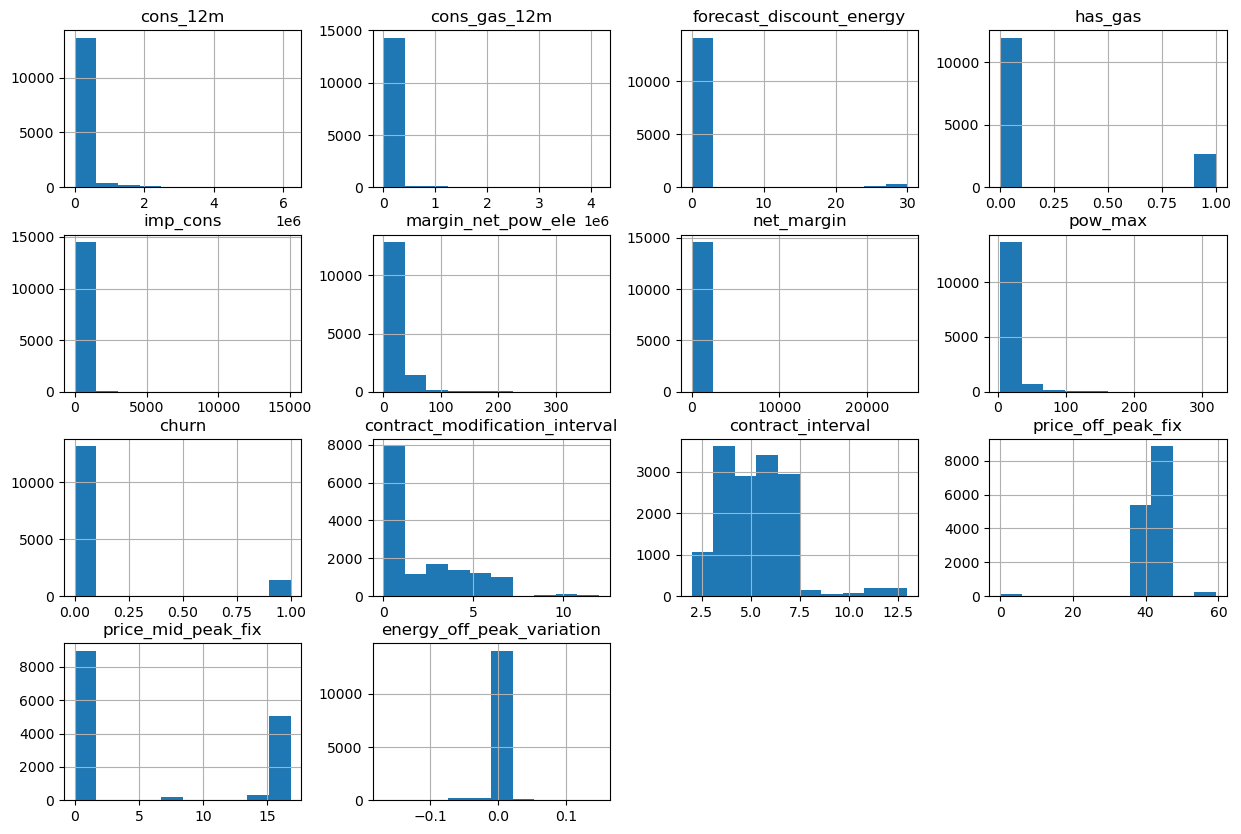

In [40]:
#univariant Analysis
df.hist(figsize=(15,10))
plt.show()

In [41]:
#Removing outliers if the feature's outliers count is less than a certain threshold from the total dataset.
#Note: The threshold of the outlier removal was selected in the manner that the minority classes were preserved
for col in ['cons_12m', 'cons_gas_12m', 'imp_cons', 'margin_net_pow_ele', 'net_margin', 
       'pow_max',  'price_mid_peak_fix','energy_off_peak_variation','price_off_peak_fix']:
    df = outlier_removal(df,col,0.08)
    print(df.churn.value_counts())

Total No of rows in actual dataframe :  14593 
Total No of rows in outliers :  2084
0    13174
1     1419
Name: churn, dtype: int64
Total No of rows in actual dataframe :  14593 
Total No of rows in outliers :  2610
0    13174
1     1419
Name: churn, dtype: int64
Total No of rows in actual dataframe :  14593 
Total No of rows in outliers :  1214
0    13174
1     1419
Name: churn, dtype: int64
Total No of rows in actual dataframe :  14593 
Total No of rows in outliers :  660
0    12635
1     1298
Name: churn, dtype: int64
Total No of rows in actual dataframe :  13933 
Total No of rows in outliers :  979
0    11764
1     1190
Name: churn, dtype: int64
Total No of rows in actual dataframe :  12954 
Total No of rows in outliers :  1190
0    11764
1     1190
Name: churn, dtype: int64
Total No of rows in actual dataframe :  12954 
Total No of rows in outliers :  0
0    11764
1     1190
Name: churn, dtype: int64
Total No of rows in actual dataframe :  12954 
Total No of rows in outliers :  46

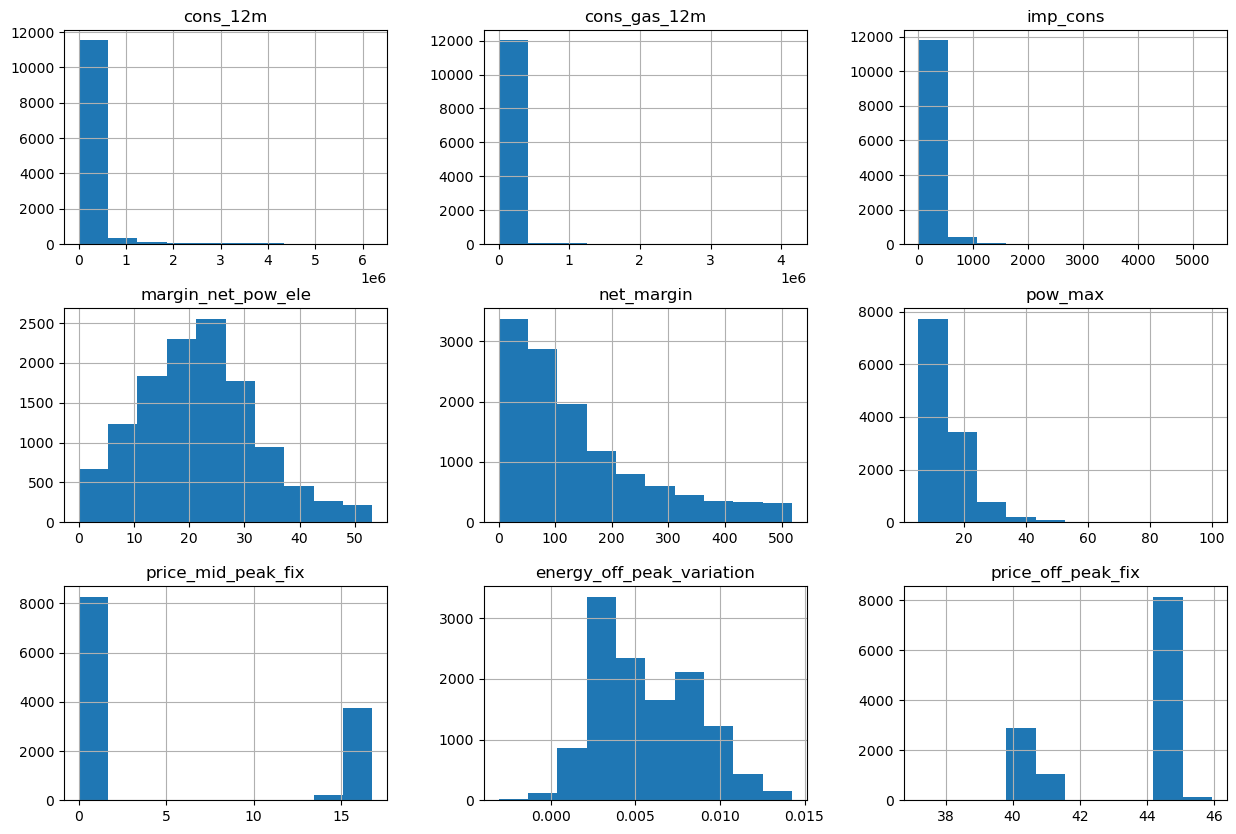

In [42]:
#Feature Distribution after removing outliers
ax = df.hist(figsize=(15,10),column=['cons_12m', 'cons_gas_12m', 'imp_cons', 'margin_net_pow_ele', 'net_margin', 
       'pow_max',  'price_mid_peak_fix','energy_off_peak_variation','price_off_peak_fix'],bins=10)
plt.show()

<h2>Feature Analysis & Visualizations</h2>

<h3>Client Churn</h3>

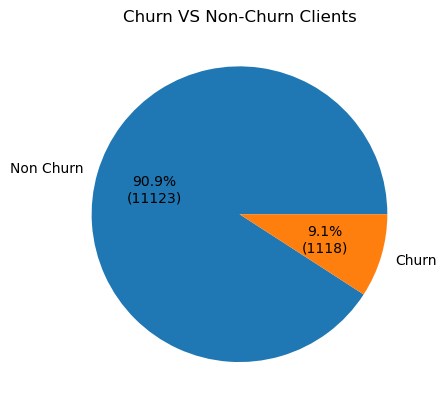

In [44]:
plt.pie(df.churn.value_counts(),
        labels=['Non Churn','Churn'], 
        autopct=lambda x : annotation_labeling(x,df.churn.value_counts().values))
plt.title('Churn VS Non-Churn Clients')
plt.show()

### Discount

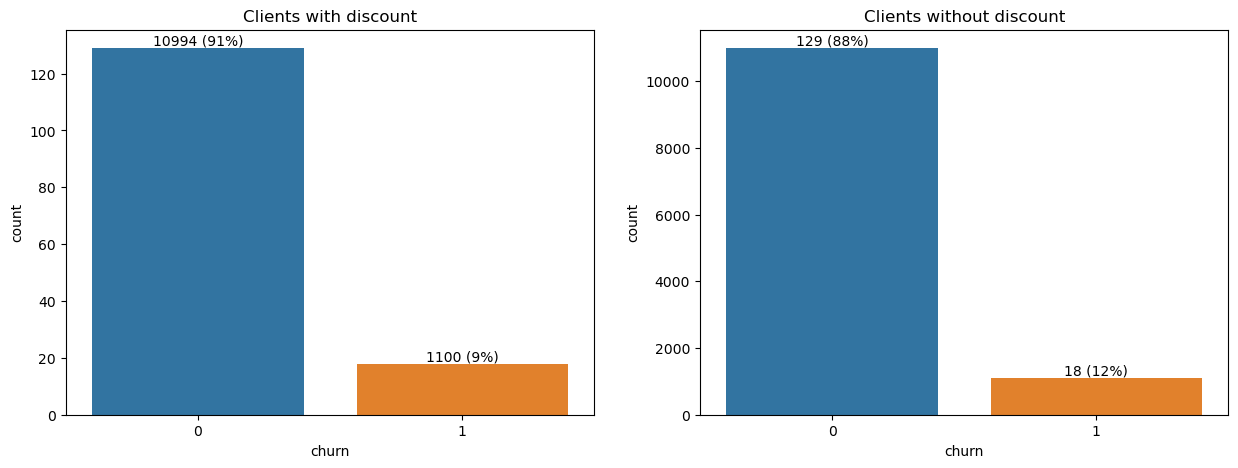

In [45]:
'''
    Here we're making assumption that customers with discount will have the forecasted discount.
    By that we divide clients as client with discount and without discount
'''
abs_values_d = df[df.forecast_discount_energy != 0].churn.value_counts(ascending=False)
rel_values_d = df[df.forecast_discount_energy != 0].churn.value_counts(ascending=False, normalize=True).values * 100
dlbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values_d, rel_values_d)]

abs_values_wd = df[df.forecast_discount_energy == 0].churn.value_counts(ascending=False)
rel_values_wd = df[df.forecast_discount_energy == 0].churn.value_counts(ascending=False, normalize=True).values * 100
wdlbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values_wd, rel_values_wd)]

plt.figure(figsize=(15,5))
plt.subplot(121)
ax1 = sns.countplot(df[df.forecast_discount_energy != 0].churn)
ax1.bar_label(container=ax1.containers[0], labels=wdlbls)
plt.title('Clients with discount')
plt.subplot(122)
ax2 = sns.countplot(df[df.forecast_discount_energy == 0].churn)
ax2.bar_label(container=ax2.containers[0], labels=dlbls)
plt.title('Clients without discount')
plt.suptitle('')
plt.show()